In [1]:
#%run ../Exploring_data/Exploratory_analysis.ipynb

In the next line we are going to choose the number of days we want to predict. For this project we have chosen 7 days, but it can be changed for investigating:

In [2]:
days = 28

# First we are consider it as a regression problem:

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [4]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column 7 days so, with the information we have today, we can predict the value for the electricity in 7 days:

In [5]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)

In [6]:
df.dropna(axis=0,how='any',inplace=True)

In [7]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [8]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_train_aux, X_test, y_train_aux, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_aux, y_train_aux, train_size=0.8,test_size=0.2, random_state=101)

In [9]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)

parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}

xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

In [10]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.3min finished


CPU times: user 1min 1s, sys: 1.41 s, total: 1min 3s
Wall time: 7min 25s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [11]:
eval_set = [(X_train, y_train), (X_validation, y_validation)]

xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:80.62905	validation_0-mae:73.21211	validation_1-rmse:80.86056	validation_1-mae:73.36064
[1]	validation_0-rmse:64.83462	validation_0-mae:58.62024	validation_1-rmse:64.99988	validation_1-mae:58.69497
[2]	validation_0-rmse:52.55335	validation_0-mae:47.01823	validation_1-rmse:52.63092	validation_1-mae:47.00967
[3]	validation_0-rmse:43.10982	validation_0-mae:37.85275	validation_1-rmse:43.17701	validation_1-mae:37.78066
[4]	validation_0-rmse:35.59941	validation_0-mae:30.63963	validation_1-rmse:35.68312	validation_1-mae:30.55083
[5]	validation_0-rmse:29.04134	validation_0-mae:24.83487	validation_1-rmse:29.11961	validation_1-mae:24.73960
[6]	validation_0-rmse:23.93198	validation_0-mae:20.27930	validation_1-rmse:24.02969	validation_1-mae:20.20741
[7]	validation_0-rmse:19.97212	validation_0-mae:16.73541	validation_1-rmse:20.10659	validation_1-mae:16.70536
[8]	validation_0-rmse:17.20630	validation_0-mae:14.16968	validation_1-rmse:17.40233	validation_1-mae:14.22495
[9]	valida

[77]	validation_0-rmse:4.79477	validation_0-mae:3.66975	validation_1-rmse:6.27424	validation_1-mae:4.74727
[78]	validation_0-rmse:4.76466	validation_0-mae:3.64838	validation_1-rmse:6.25421	validation_1-mae:4.73224
[79]	validation_0-rmse:4.74502	validation_0-mae:3.63235	validation_1-rmse:6.24083	validation_1-mae:4.72120
[80]	validation_0-rmse:4.73715	validation_0-mae:3.62570	validation_1-rmse:6.23696	validation_1-mae:4.71760
[81]	validation_0-rmse:4.71537	validation_0-mae:3.60833	validation_1-rmse:6.22710	validation_1-mae:4.70977
[82]	validation_0-rmse:4.68830	validation_0-mae:3.58633	validation_1-rmse:6.20948	validation_1-mae:4.69629
[83]	validation_0-rmse:4.67502	validation_0-mae:3.57728	validation_1-rmse:6.20724	validation_1-mae:4.69359
[84]	validation_0-rmse:4.63091	validation_0-mae:3.54471	validation_1-rmse:6.17212	validation_1-mae:4.66389
[85]	validation_0-rmse:4.62773	validation_0-mae:3.54153	validation_1-rmse:6.17034	validation_1-mae:4.66245
[86]	validation_0-rmse:4.60713	valida

[154]	validation_0-rmse:3.52861	validation_0-mae:2.69046	validation_1-rmse:5.51018	validation_1-mae:4.15153
[155]	validation_0-rmse:3.52142	validation_0-mae:2.68490	validation_1-rmse:5.50636	validation_1-mae:4.14799
[156]	validation_0-rmse:3.50973	validation_0-mae:2.67602	validation_1-rmse:5.50123	validation_1-mae:4.14269
[157]	validation_0-rmse:3.49161	validation_0-mae:2.66262	validation_1-rmse:5.49080	validation_1-mae:4.13498
[158]	validation_0-rmse:3.48116	validation_0-mae:2.65360	validation_1-rmse:5.48710	validation_1-mae:4.13190
[159]	validation_0-rmse:3.47650	validation_0-mae:2.64985	validation_1-rmse:5.48533	validation_1-mae:4.13071
[160]	validation_0-rmse:3.46810	validation_0-mae:2.64318	validation_1-rmse:5.48308	validation_1-mae:4.12791
[161]	validation_0-rmse:3.45587	validation_0-mae:2.63549	validation_1-rmse:5.47679	validation_1-mae:4.12428
[162]	validation_0-rmse:3.45025	validation_0-mae:2.63094	validation_1-rmse:5.47320	validation_1-mae:4.12237
[163]	validation_0-rmse:3.43

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.2, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [12]:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Precio_mercado_SPOT_Intradiario_Sesion_3,Precio_mercado_SPOT_Intradiario_Sesion_4,Precio_mercado_SPOT_Intradiario_Sesion_5,Precio_mercado_SPOT_Intradiario_Sesion_6,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.003724,0.000214,0.004452,0.019145,0.008537,0.001236,0.000966,0.035831,0.122861,0.337667,...,0.000382,0.000349,0.00075,0.000694,0.000311,0.000573,0.000491,0.000415,0.000602,0.000455


In [13]:
np.sqrt(abs(xgb_mod.best_score_))

5.466663084255492

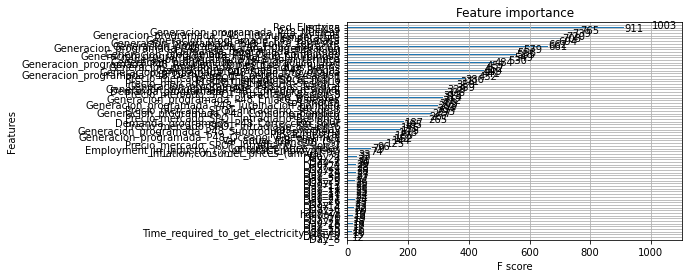

In [14]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [15]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 

In [16]:
np.sqrt(mean_squared_error(y_test, y_pred))

5.234793516103355

In [17]:
r2_score(y_test, y_pred)

0.9821185108157016

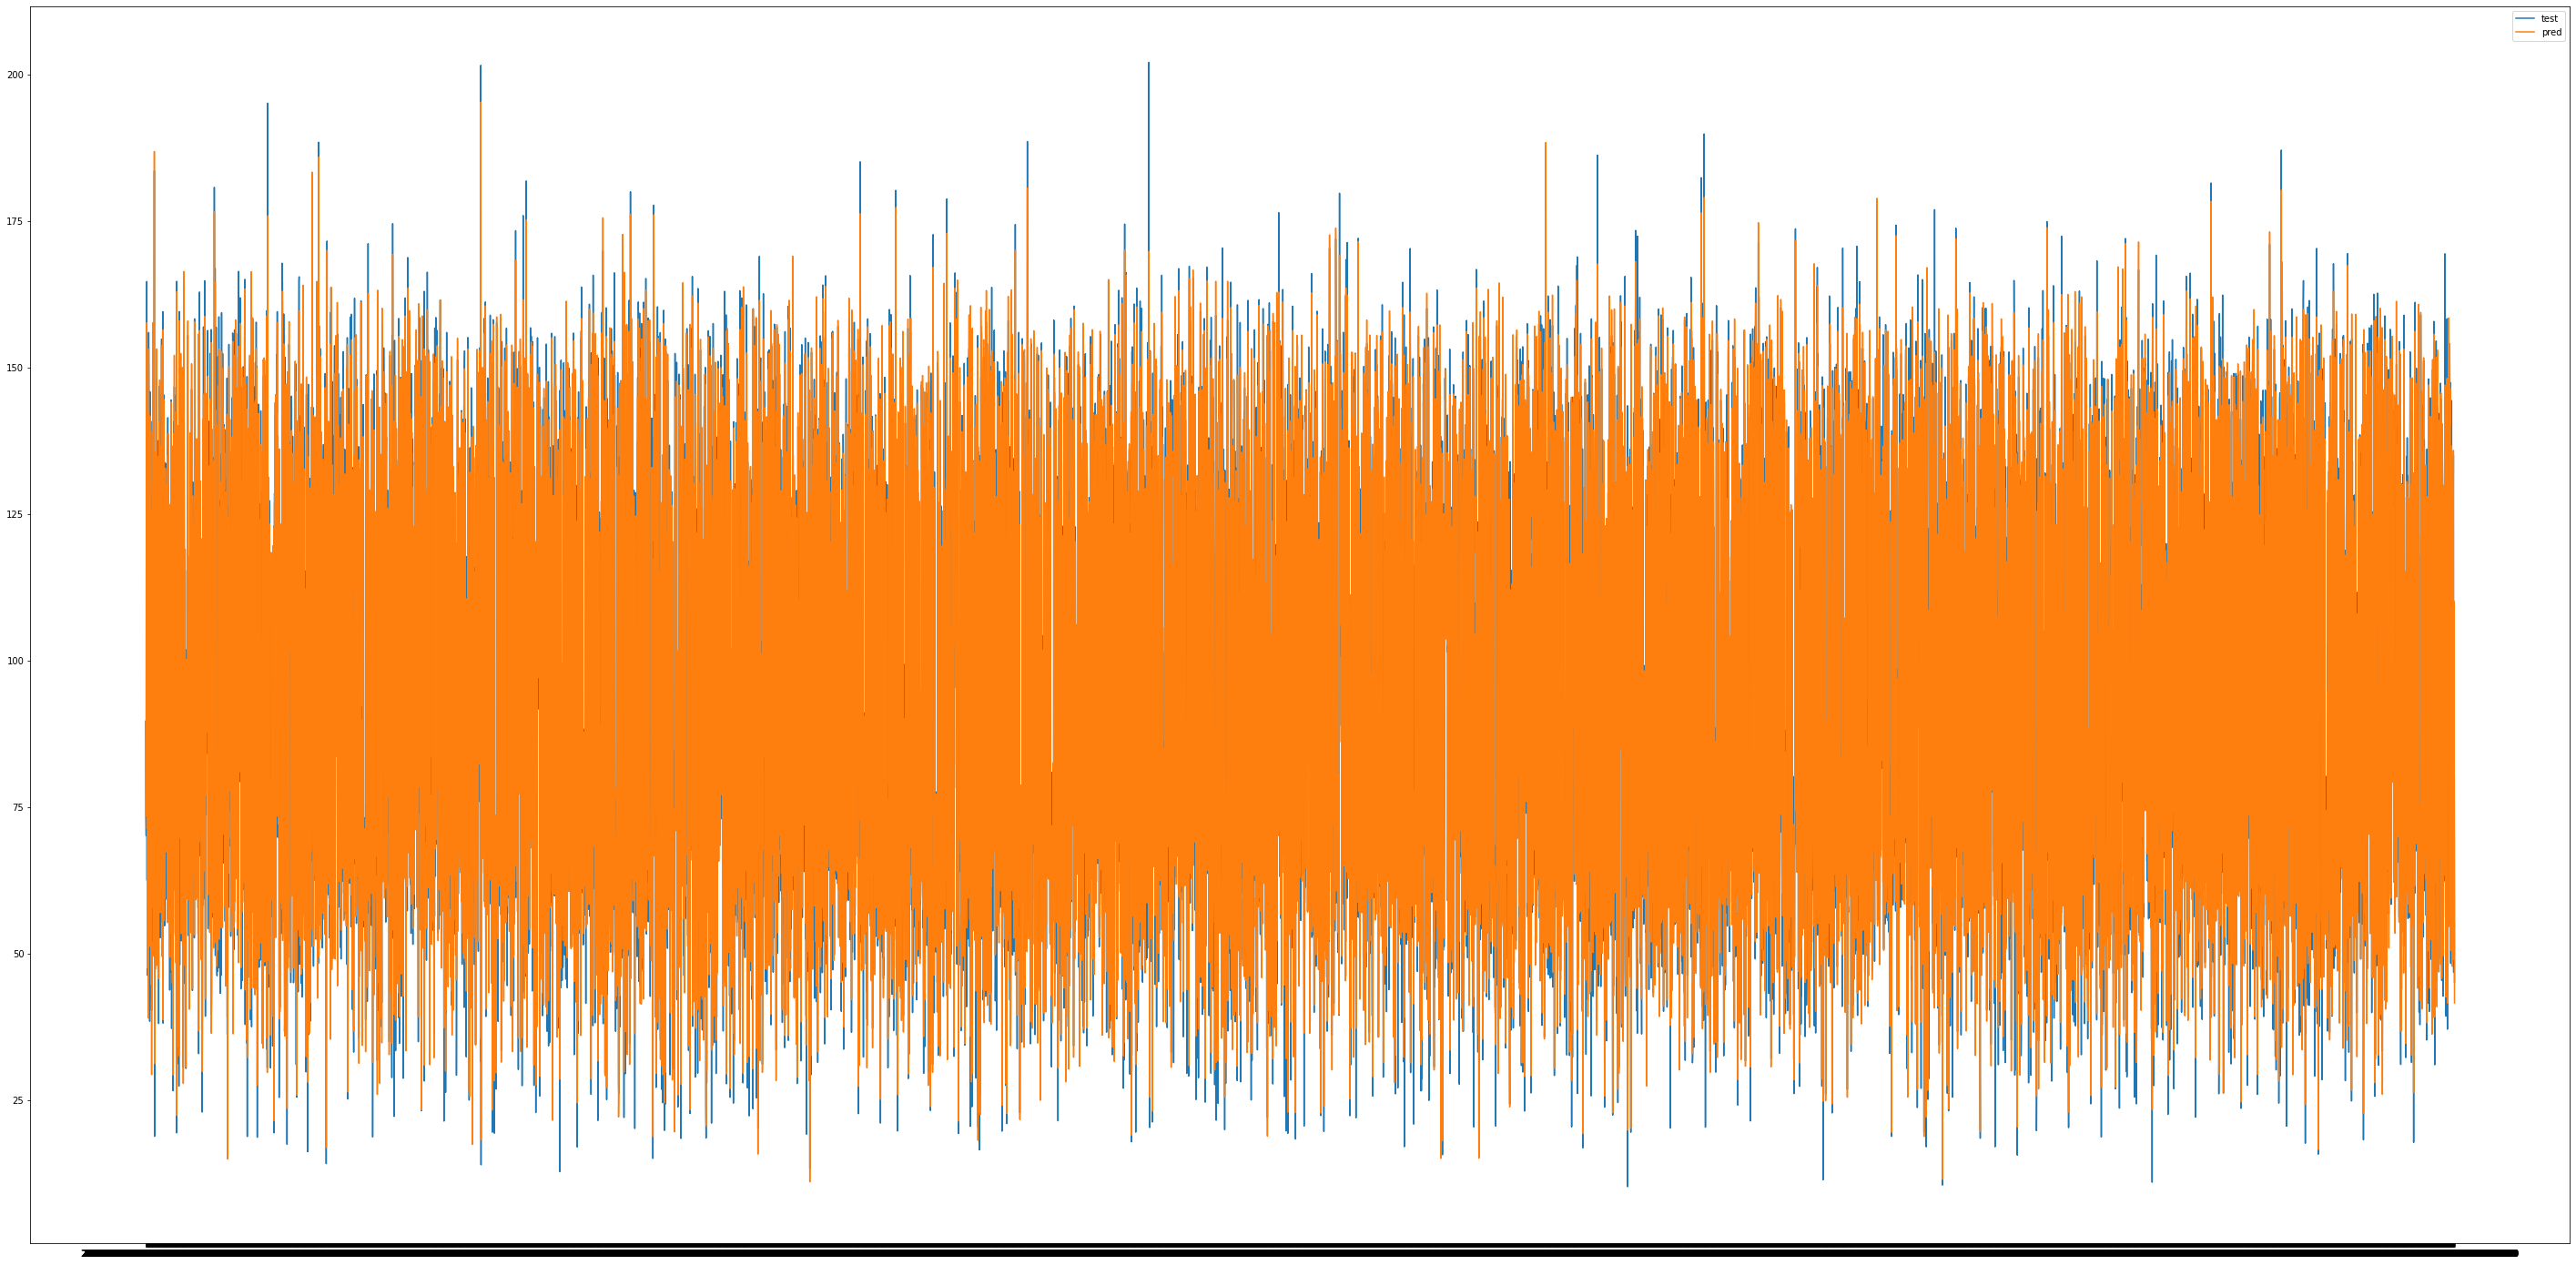

In [18]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

In [19]:
pd.DataFrame({'y_test':y_test, 'y_pred':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost.csv')

# If we consider it as a time series problem:

In [20]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column 7 days so, with the information we have today, we can predict the value for the electricity in 7 days:

In [ ]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-24*days)

In [ ]:
df.dropna(axis=0,how='any',inplace=True)

In [ ]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Precio_mercado_SPOT_Intradiario_Sesion_3',
                 'Precio_mercado_SPOT_Intradiario_Sesion_4',
                 'Precio_mercado_SPOT_Intradiario_Sesion_5',
                 'Precio_mercado_SPOT_Intradiario_Sesion_6',
                 'Precio_mercado_SPOT_Intradiario_Sesion_7',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

standarized_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature']

In [ ]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[standarized_columns]) 

X[standarized_columns] = scaled_data

y_train = df.loc[:'2018-06-01 00:00:00+00:00','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_train = df.loc[:'2018-06-01 00:00:00+00:00',model_columns]
y_validation = df.loc['2018-06-01 00:00:00+00:00':'2019-06-01 00:00:00+00:00','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_validation = df.loc['2018-06-01 00:00:00+00:00':'2019-06-01 00:00:00+00:00',model_columns]
y_test = df.loc['2019-06-01 00:00:00+00:00':,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_test = df.loc['2019-06-01 00:00:00+00:00':,model_columns]

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)

parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}

xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

In [ ]:
%%time
xgb_mod.fit(X_train,y_train)

In [ ]:
eval_set = [(X_train, y_train), (X_validation, y_validation)]

xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

In [ ]:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

In [ ]:
np.sqrt(abs(xgb_mod.best_score_))

In [ ]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
r2_score(y_test,y_pred)

In [ ]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({'y_test':y_test, 'y_pred':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost_time_series.csv')